In [1]:
from model_pytorch import *
import os 
import pickle
from cfg import Config
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time

<Figure size 640x480 with 1 Axes>

In [2]:
config = Config()

In [3]:
config.p_path

'./pickels/conv.p'

In [4]:
n_samples = 2 * int(df['length'].sum()/0.1)

In [5]:
prob_dist = class_dist /class_dist.sum()

In [6]:
np.random.choice(class_dist.index,p=prob_dist)

'Snare_drum'

In [27]:
def check_data():
    if os.path.isfile(config.p_path):
        print ('Loading existing data from {} model'.format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [ ]:
os.path.isfile(config.p_path)

In [ ]:
class_dist

In [28]:
def return_sample(dummy) :
    _min,_max = float('inf'),-float('inf')
#     rand_class = np.random.choice(class_dist.index,p=prob_dist)
    rand_class = np.random.choice(class_dist.index)
    file = np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('clean/'+file)
    label = df.at[file,'label']
    rand_index = np.random.randint(0,wav.shape[0]-config.step)
    sample = wav[rand_index:rand_index+config.step]
    X_sample = mfcc(sample,rate,numcep=config.nfeat
                   ,nfilt=config.nfilt,nfft=config.nfft)

    #         X_sample= logfbank(sample,rate,nfilt=config.nfilt,nfft=config.nfft).T

    return X_sample,classes.index(label)


In [29]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        print ('data exist')
        return tmp.data[0], tmp.data[1]
    
    X = []
    y = []
    _min,_max = float('inf'),-float('inf')
    import multiprocessing
    pool = multiprocessing.Pool(4)
    total_samples = 200000
    results= list(tqdm(pool.imap_unordered(return_sample,range(total_samples)),total=total_samples))
    pool.close()
#     for _ in tqdm(range(10000)):
#         rand_class = np.random.choice(class_dist.index,p=prob_dist)
#         file = np.random.choice(df[df.label==rand_class].index)
#         rate, wav = wavfile.read('clean/'+file)
#         label = df.at[file,'label']
#         rand_index = np.random.randint(0,wav.shape[0]-config.step)
#         sample = wav[rand_index:rand_index+config.step]
#         X_sample = mfcc(sample,rate,numcep=config.nfeat
#                        ,nfilt=config.nfilt,nfft=config.nfft)
        
# #         X_sample= logfbank(sample,rate,nfilt=config.nfilt,nfft=config.nfft).T
        
#         _min = min(np.amin(X_sample),_min)
#         _max = max(np.amax(X_sample),_max)
#         X.append(X_sample)
#         y.append(classes.index(label))
    for result in results :
        _min = min(np.amin(result[0]),_min)
        _max = max(np.amin(result[0]),_max)
        X.append(result[0])
        y.append(result[1])


    config.min = _min
    config.max = _max
    X,y = np.array(X), np.array(y)
    X = (X - _min) / (_max-_min)
#     if config.mode == 'conv':
#         X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
#     elif config.mode == 'time':
#         X= X.reshape(X.shape[0],X.shape[1],X.shape[2])
    config.data = (X,y)
    
    with open('./pickels/conv.p','wb') as handle:
        pickle.dump(config,handle,protocol=2)
        
    return X,y

In [10]:
df.shape

(300, 2)

In [43]:
rate, wav = wavfile.read('clean/00353774.wav')

In [ ]:
wav.shape

In [ ]:
 X_sample = mfcc(wav[:1000],rate,numcep=config.nfeat
                       ,nfilt=config.nfilt,nfft=config.nfft)


In [ ]:
 X_sample = logfbank(wav[:1000],rate
                       ,nfilt=config.nfilt,nfft=config.nfft)


In [36]:
from scipy.signal import stft

In [ ]:
 X_sample = logfbank(wav[:1000],rate
                       ,nfilt=config.nfilt,nfft=config.nfft)


In [ ]:
 X_sample = mfcc(wav[:1000],rate
                       ,nfilt=config.nfilt,nfft=config.nfft)


In [44]:
f, t, Zxx = stft(wav[:1000],rate,nperseg=config.nfft)

In [ ]:
Zxx.shape

In [46]:
from eda import plot_fft

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

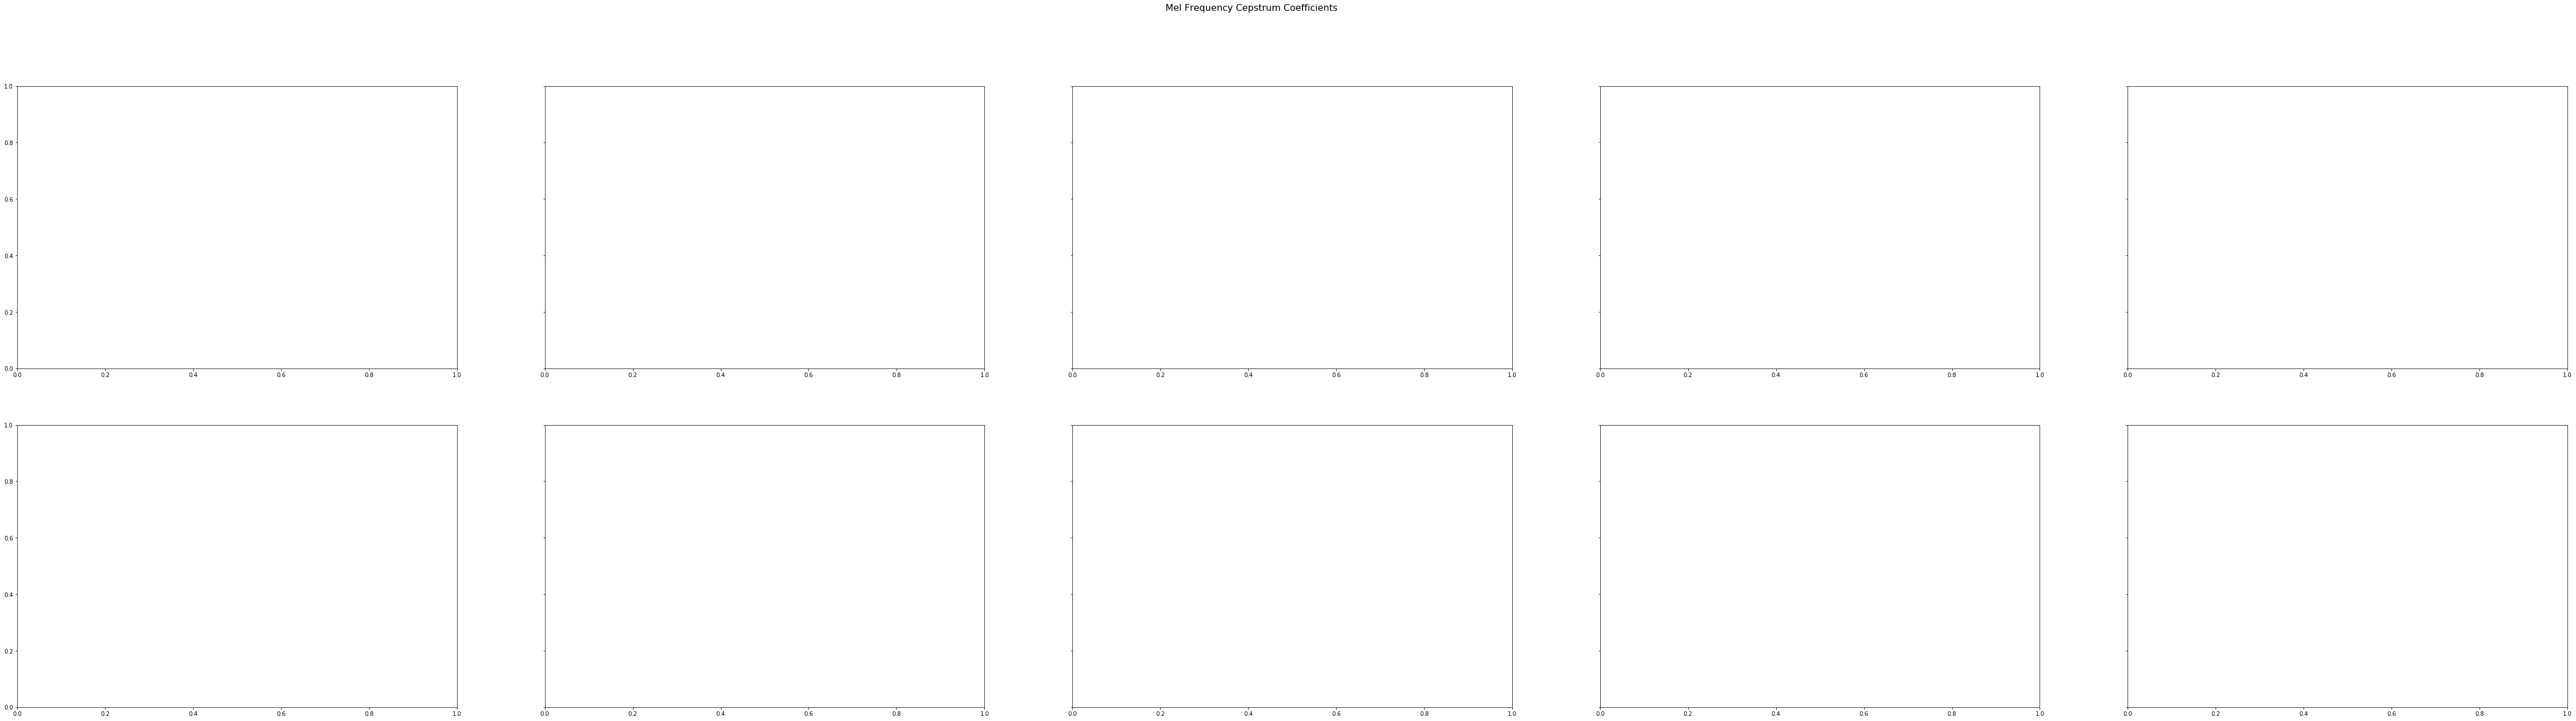

In [45]:
plot_fft()

In [ ]:
X_sample.shape

In [ ]:
# class Config:
#     def __init__(self,mode='conv',nfilt=26,nfeat=13,nfft=512,rate=16000):
#         self.mode=mode
#         self.nfilt = nfilt
#         self.nfeat = nfeat
#         self.nfft = nfft
#         self.rate =rate
#         self.step = int(rate/10)

https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

<img src="https://www.pyimagesearch.com/wp-content/uploads/2018/12/keras_conv2d_num_filters.png">

In [ ]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [30]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
      
        # 28x28x1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
        # 28x28x8 => 14x14x8
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(14-1) - 28 + 2) = 0                                       
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x16 => 7x7x16                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0
        
        
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                  out_channels=16,
                                  kernel_size=(3, 3),
                                  stride=(1, 1),
                                  padding=1) 
        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                              out_channels=32,
                              kernel_size=(3, 3),
                              stride=(1, 1),
                              padding=1) 
        self.conv_3 = torch.nn.Conv2d(in_channels=32,
                              out_channels=64,
                              kernel_size=(3, 3),
                              stride=(1, 1),
                              padding=1) 
        self.conv_4 = torch.nn.Conv2d(in_channels=64,
                              out_channels=128,
                              kernel_size=(3, 3),
                              stride=(1, 1),
                              padding=1)
        
        
        self.max_pool = torch.nn.MaxPool2d(kernel_size=(2, 2))
        

        self.linear_1 = torch.nn.Linear(3072, 128)

        self.linear_2 = torch.nn.Linear(128, 64)

        self.linear_3 = torch.nn.Linear(64, 10)

        
        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.conv_2(out)
        out = F.relu(out)
        out = self.conv_3(out)
        out = F.relu(out)
        out = self.conv_4(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = out.flatten(start_dim=1, end_dim=-1)
        out = self.linear_1(out)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        logits = F.relu(out)
        
        
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [31]:
X,y = build_rand_feat()

Loading existing data from conv model
data exist


In [ ]:
#     with open('./pickels/conv.p','wb') as handle:
#         pickle.dump(config,handle,protocol=2)

In [ ]:
with open('./pickels/conv.p','rb') as handle:
    config = pickle.load(handle)

In [33]:
model = ConvNet(10).cuda()

In [32]:
del model

In [ ]:
res=model(torch.tensor(X[:3].reshape(3,1,9,13)).float().cuda())

In [ ]:
res[0].shape

In [ ]:
logits = self.linear_1(out.view(-1, out.shape[1]*out.shape[2]*out.shape[3]))
probas = F.softmax(logits, dim=1)
return logits, probas

In [ ]:
y.shape

In [ ]:
torch.tensor(X.reshape(100,1,9,13)).shape

In [ ]:
config= Config(mode='conv')

In [ ]:
config.p_path

In [ ]:
if config.mode == 'conv':
    X,y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1],X.shape[2],1)
    model = get_conv_model()
if config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1],X.shape[2])
    model = get_recurrent_model()

In [ ]:
model = get_recurrent_model()

In [ ]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [ ]:
X.shape

In [25]:
train_loader = DataLoader(dataset=list(zip(X.reshape(200000,1,9,13),y)), 
                          batch_size=100, 
                          shuffle=True)

In [34]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device).float()
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
learning_rate = 0.1
num_epochs = 30
device= 'cuda'
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features.float().cuda())


        cost = F.cross_entropy(logits, targets.cuda())

        
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/030 | Batch 000/2000 | Cost: 2.3106
Epoch: 001/030 | Batch 050/2000 | Cost: 2.3024
Epoch: 001/030 | Batch 100/2000 | Cost: 2.3009
Epoch: 001/030 | Batch 150/2000 | Cost: 2.2995
Epoch: 001/030 | Batch 200/2000 | Cost: 2.3002
Epoch: 001/030 | Batch 250/2000 | Cost: 2.3041
Epoch: 001/030 | Batch 300/2000 | Cost: 2.2982
Epoch: 001/030 | Batch 350/2000 | Cost: 2.2949
Epoch: 001/030 | Batch 400/2000 | Cost: 2.2936
Epoch: 001/030 | Batch 450/2000 | Cost: 2.2946
Epoch: 001/030 | Batch 500/2000 | Cost: 2.2468
Epoch: 001/030 | Batch 550/2000 | Cost: 1.9061
Epoch: 001/030 | Batch 600/2000 | Cost: 1.6765
Epoch: 001/030 | Batch 650/2000 | Cost: 1.6920
Epoch: 001/030 | Batch 700/2000 | Cost: 1.2454
Epoch: 001/030 | Batch 750/2000 | Cost: 1.1374
Epoch: 001/030 | Batch 800/2000 | Cost: 1.0283
Epoch: 001/030 | Batch 850/2000 | Cost: 0.9918
Epoch: 001/030 | Batch 900/2000 | Cost: 1.0014
Epoch: 001/030 | Batch 950/2000 | Cost: 0.7623
Epoch: 001/030 | Batch 1000/2000 | Cost: 0.6500
Epoch: 001/0

KeyboardInterrupt: 

In [ ]:
targets

In [ ]:
logits

In [24]:
torch.cuda.empty_cache()

In [ ]:
model.save(config.model_path)